
## Image Captioning with Conditioned LSTM Generators



### Environment Setup  

In [ ]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt
%matplotlib inline

from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam

from google.colab import drive

### Access to the flickr8k data

In this project we use the flickr8k data set, which is accessed here: https://forms.illinois.edu/sec/1713398


Reference:
> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results


In [ ]:
my_data_dir="hw5_data"

### Mounting GDrive so we can access the files from Colab

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Image Encodings 

The files Flickr_8k.trainImages.txt Flickr_8k.devImages.txt Flickr_8k.testImages.txt, contain a list of training, development, and test images, respectively.

In [ ]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [ ]:
train_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.trainImages.txt')
dev_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.devImages.txt')
test_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.testImages.txt')

Let's see how many images there are

In [ ]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [ ]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [ ]:
IMG_PATH = "/content/gdrive/My Drive/hw5_data/Flickr8k_Dataset"

We can use PIL to open the image and matplotlib to display it. 

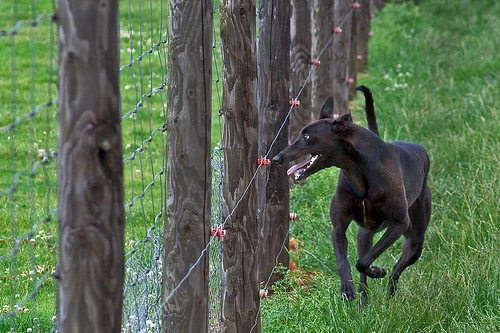

In [ ]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. 

Reference:
> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [ ]:
np.asarray(image).shape

(333, 500, 3)

The values range from 0 to 255. 

In [ ]:
np.asarray(image)

array([[[118, 161,  89],
        [120, 164,  89],
        [111, 157,  82],
        ...,
        [ 68, 106,  65],
        [ 64, 102,  61],
        [ 65, 104,  60]],

       [[125, 168,  96],
        [121, 164,  92],
        [119, 165,  90],
        ...,
        [ 72, 115,  72],
        [ 65, 108,  65],
        [ 72, 115,  70]],

       [[129, 175, 102],
        [123, 169,  96],
        [115, 161,  88],
        ...,
        [ 88, 129,  87],
        [ 75, 116,  72],
        [ 75, 116,  72]],

       ...,

       [[ 41, 118,  46],
        [ 36, 113,  41],
        [ 45, 111,  49],
        ...,
        [ 23,  77,  15],
        [ 60, 114,  62],
        [ 19,  59,   0]],

       [[100, 158,  97],
        [ 38, 100,  37],
        [ 46, 117,  51],
        ...,
        [ 25,  54,   8],
        [ 88, 112,  76],
        [ 65, 106,  48]],

       [[ 89, 148,  84],
        [ 44, 112,  35],
        [ 71, 130,  72],
        ...,
        [152, 188, 142],
        [113, 151, 110],
        [ 94, 138,  75]]

We can use PIL to resize the image and then divide every value by 255. 

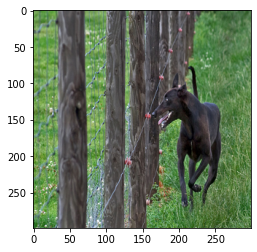

In [ ]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [ ]:
new_image.shape

(299, 299, 3)

Put this all in a function for convenience. 

In [ ]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0                      

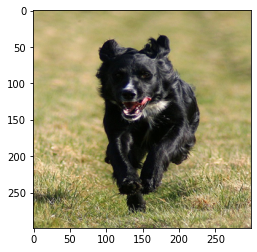

In [ ]:
plt.imshow(get_image(dev_list[25]))

### Load the pre-trained Inception model. 

In [ ]:
# Might take a while to load
img_model = InceptionV3(weights='imagenet') 

96124928/96112376 [==============================] - 2s 0us/step


In [ ]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We will use the following hack: hook up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

In [ ]:
encoded_image = img_encoder.predict(np.array([new_image]))

In [ ]:
encoded_image

array([[0.6380663 , 0.48873007, 0.05526244, ..., 0.64255697, 0.2959524 ,
        0.49004316]], dtype=float32)

### Create encodings for all images

In [ ]:
# The following generator function will return one image at a time. 
# img_list is a list of image file names (i.e. the train, dev, or test set). 
# The return value should be a numpy array of shape (1,299,299,3).
def img_generator(img_list):
  for file_name in img_list:
    image = get_image(file_name)
    yield np.array(image, ndmin=4)

Now we can encode all images (this takes a few minutes).

In [ ]:
enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


6000/6000 [==============================] - 3501s 583ms/step


In [ ]:
enc_train[11]

array([0.268186  , 1.032166  , 0.585162  , ..., 1.2316743 , 0.17969316,
       0.22405316], dtype=float32)

In [ ]:
enc_dev = img_encoder.predict_generator(img_generator(dev_list), steps=len(dev_list), verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


1000/1000 [==============================] - 573s 573ms/step


In [ ]:
enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


1000/1000 [==============================] - 570s 571ms/step


Save the resulting matrices, so we do not have to run the encoder again. 

In [ ]:
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy", enc_train)
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy", enc_dev)
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_test.npy", enc_test)

# Text (Caption) Data Preparation

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

In [ ]:
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)    
    # ...
    files = open(filename, 'r')

    for file in files:
      file_name = file.split('#')[0]
      caption = file.split('#')[1].split('\t')[1].split()
      # Convert each token to lower case
      caption = [word.lower() for word in caption]
      # Pad each caption with a START token on the left
      caption.insert(0, '<START>')
      # and an END token on the right
      caption.append('<END>')

      image_descriptions[file_name].append(caption)
    
    return image_descriptions

In [ ]:
descriptions = read_image_descriptions("gdrive/My Drive/"+my_data_dir+"/Flickr8k.token.txt")

In [ ]:
print(descriptions[dev_list[0]])

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


### Creating Word Indices

In [ ]:
# Create a set of tokens in the training data
tokens = []
for captions in descriptions.values():
  for caption in captions:
    for word in caption:
      tokens.append(word)
tokens = set(tokens)

# Convert the set into a list and sort it
tokens = list(tokens)
tokens.sort()

In [ ]:
id_to_word = defaultdict()
n = len(tokens)
for i in range(n):
  id_to_word[i] = tokens[i]

In [ ]:
word_to_id = {value: k for k, value in id_to_word.items()}

In [ ]:
word_to_id['dog'] # should print an integer

2307

In [ ]:
id_to_word[1985] # should print a token

'crudely'

Note that we do not need an UNK word token because we are generating. The generated text will only contain tokens seen at training time.  

# Basic Decoder Model

For now, we will just train a model for text generation without conditioning the generator on the image input. 


The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [ ]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

40

In [ ]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 300)           2675100   
                                                                 
 bidirectional (Bidirectiona  (None, 1024)             3330048   
 l)                                                              
                                                                 
 dense (Dense)               (None, 8917)              9139925   
                                                                 
Total params: 15,145,073
Trainable params: 15,145,073
Non-trainable params: 0
_________________________________________________________________


The model input is a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with 0. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a numpy ndarray of size `(batch_size, vocab_size)`. vocab_size is the number of vocabulary words. 

### Creating a Generator for the Training Data

In [ ]:
def text_training_generator(batch_size=128):
    input = []
    output = []

    while(True):
      for path in train_list:
        for caption in descriptions[path]:
          for i in range(len(caption)-1):
            count = 0 
            generator_num = np.zeros(40) #If the input sequence is shorter than MAX_LEN, padded with 0
            generator = caption[:i+1]
            word = caption[i+1]
            word_index = word_to_id[word]
            
            for word in generator:
              generator_num[count]=word_to_id[word]
              count += 1
            
            input.append(generator_num) 
            one_hot_encoding = to_categorical(word_index, vocab_size)
            output.append(one_hot_encoding)
  
            if(len(input)==128):
              input = np.asarray(input)
              output = np.asarray(output) 
              reshaped_input= np.reshape(input,(batch_size, 40))
              reshaped_output= np.reshape(output,(batch_size, vocab_size))
              yield (reshaped_input, reshaped_output)
              
              input=[]
              output=[]

### Training the Model

We will use the `fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.

Because there are len(train_list) training samples with up to `MAX_LEN` words, an upper bound for the number of total training instances is `len(train_list)*MAX_LEN`. Because the generator returns these in batches, the number of steps is len(train_list) * MAX_LEN // batch_size

In [ ]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [ ]:
model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


1875/1875 [==============================] - 204s 106ms/step - loss: 4.2589 - accuracy: 0.2955
Epoch 2/10
1875/1875 [==============================] - 197s 105ms/step - loss: 3.7056 - accuracy: 0.3574
Epoch 3/10
1875/1875 [==============================] - 197s 105ms/step - loss: 3.5340 - accuracy: 0.3736
Epoch 4/10
1875/1875 [==============================] - 197s 105ms/step - loss: 3.4350 - accuracy: 0.3832
Epoch 5/10
1875/1875 [==============================] - 197s 105ms/step - loss: 3.3821 - accuracy: 0.3893
Epoch 6/10
1875/1875 [==============================] - 197s 105ms/step - loss: 3.3112 - accuracy: 0.3956
Epoch 7/10
1875/1875 [==============================] - 197s 105ms/step - loss: 3.2918 - accuracy: 0.3988
Epoch 8/10
1875/1875 [==============================] - 197s 105ms/step - loss: 3.2804 - accuracy: 0.4011
Epoch 9/10
1875/1875 [==============================] - 197s 105ms/step - loss: 3.2524 - accuracy: 0.4034
Epoch 10/10
1875/1875 [==============================] - 

### Greedy Decoder
 

In [ ]:
def decoder():
  prediction = "<START>"
  output = ["<START>"]

  i = 1
  sequence = np.zeros(MAX_LEN)
  # Start with the sequence ["<START>"]
  sequence[0] = word_to_id["<START>"]

  while(i < MAX_LEN and prediction != "<END>" ):
    # Use the model to predict the most likely word
    word_pred = model.predict(np.array([sequence]))
    id = np.where(word_pred == np.amax(word_pred))
    sequence[i]= id[1][0]
    prediction = id_to_word[id[1][0]]
    output.append(prediction)
    
    i += 1
    
  return output

In [ ]:
print(decoder())

['<START>', 'a', 'man', 'and', 'a', 'woman', 'stand', 'on', 'a', 'street', 'near', 'a', 'building', '.', '<END>']


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. 

Reference: [np.random.multinomial](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html) 

In [ ]:
def sample_decoder():
  prediction = "<START>"
  output = ["<START>"]

  count = 1
  sequence = np.zeros(MAX_LEN)
  sequence[0] = word_to_id["<START>"]

  while(count < 40 and prediction != "<END>"):
    pred = model.predict(np.array([sequence]))
    pred = pred.tolist()[0]

    norm = []
    for i in pred:
      norm.append(i/sum(pred))

    multi = np.random.multinomial(10, norm, size=None)
    id = np.where(multi == np.amax(multi)) 

    sequence[count] = id[0][0]
    prediction = id_to_word[id[0][0]]
    output.append(prediction)
    count += 1

  return output

In [ ]:
for i in range(10): 
    print(sample_decoder())

['<START>', 'a', 'dog', 'is', 'running', '.', '<END>']
['<START>', 'a', 'child', 'in', 'a', 'red', 'shirt', 'is', 'around', 'a', 'and', 'white', 'water', 'on', 'a', 'beach', '.', '<END>']
['<START>', 'a', 'man', 'wearing', 'a', 'blue', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'crowd', '.', '<END>']
['<START>', 'a', 'man', 'is', 'sitting', 'in', 'the', 'snow', 'with', 'a', 'man', 'behind', 'him', '.', '<END>']
['<START>', 'a', 'boy', 'wearing', 'a', 'blue', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'blue', 'building', '.', '<END>']
['<START>', 'a', 'man', 'and', 'a', 'woman', 'are', 'walking', 'down', 'the', 'street', 'in', 'front', 'of', 'a', 'man', 'wearing', 'a', 'black', 'shirt', '.', '<END>']
['<START>', 'a', 'man', ',', 'and', 'girl', 'are', 'standing', 'by', 'a', 'blue', 'and', 'white', 'arm', '.', '<END>']
['<START>', 'a', 'dog', 'runs', 'along', 'the', 'beach', '.', '<END>']
['<START>', 'a', 'man', 'with', 'a', 'white', ',', 'a', 'blue', 'and', 'white', '

# Conditioning on the Image

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [ ]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 300)          614700      ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector (RepeatVector)   (None, 40, 300)      0           ['dense_1[0][0]']                
                                                                                            

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

In [ ]:
enc_train = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy")
enc_dev = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy")

In [ ]:
def training_generator(batch_size=128):
  image_inputs = []
  text_inputs = []
  output = []

  while(True):
    for index in range(len(train_list)): # list of training image
      name = train_list[index]
      encoding = enc_train[index]
      for caption in descriptions[name]: # list of captions
        for i in range(len(caption)-1):  
          count = 0
          generator_num = np.zeros(MAX_LEN)
          generator = caption[:i+1]
          word = caption[i+1]
          word_index = word_to_id[word]

          for word in generator:
              generator_num[count]=word_to_id[word]
              count += 1

          image_inputs.append(encoding)
          text_inputs.append(generator_num)
          one_hot_encoding = to_categorical(word_index, vocab_size)
          output.append(one_hot_encoding)
          
          if(len(text_inputs)==128):
            image_inputs = np.asarray(image_inputs)
            text_inputs = np.asarray(text_inputs)
            output = np.asarray(output) 
            reshaped_image_inputs = np.reshape(image_inputs, (batch_size,2048))
            reshaped_text_inputs = np.reshape(text_inputs,(batch_size, 40))
            reshaped_output = np.reshape(output,(batch_size, vocab_size))
            yield ([reshaped_image_inputs, reshaped_text_inputs], reshaped_output)

            image_inputs = []
            text_inputs = []
            output = []

In [ ]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [ ]:
model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


1875/1875 [==============================] - 134s 69ms/step - loss: 4.4991 - accuracy: 0.2564
Epoch 2/20
1875/1875 [==============================] - 129s 69ms/step - loss: 3.6430 - accuracy: 0.3646
Epoch 3/20
1875/1875 [==============================] - 129s 69ms/step - loss: 3.4418 - accuracy: 0.3865
Epoch 4/20
1875/1875 [==============================] - 129s 69ms/step - loss: 3.3389 - accuracy: 0.3949
Epoch 5/20
1875/1875 [==============================] - 129s 69ms/step - loss: 3.2923 - accuracy: 0.4019
Epoch 6/20
1875/1875 [==============================] - 129s 69ms/step - loss: 3.2296 - accuracy: 0.4073
Epoch 7/20
1875/1875 [==============================] - 129s 69ms/step - loss: 3.2357 - accuracy: 0.4097
Epoch 8/20
1875/1875 [==============================] - 128s 68ms/step - loss: 3.2388 - accuracy: 0.4114
Epoch 9/20
1875/1875 [==============================] - 128s 69ms/step - loss: 3.2273 - accuracy: 0.4152
Epoch 10/20
1875/1875 [==============================] - 128s 68ms

In [ ]:
model.save_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

to load the model: 

In [ ]:
model.load_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

Modify the simple greedy decoder for the text-only generator so that it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

In [ ]:
def image_decoder(enc_image): 
  prediction = "<START>"
  output = ["<START>"]

  i = 1
  sequence = np.zeros(MAX_LEN)
  sequence[0] = word_to_id["<START>"]

  while( i < 40 and prediction != "<END>" ):
    pred = model.predict([np.array([enc_image]),np.array([sequence])])
    id = np.where(pred == np.amax(pred))
    sequence[i]= id[1][0]
    prediction = id_to_word[id[1][0]]
    output.append(prediction)
    
    i += 1

  return output

['<START>', 'a', 'dog', 'runs', 'through', 'the', 'water', '.', '<END>']

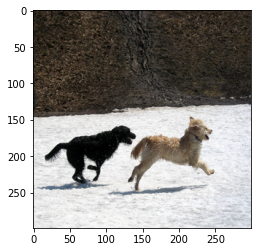

In [ ]:
plt.imshow(get_image(train_list[0]))
image_decoder(enc_train[0])

Now we can apply the model to dev images and get reasonable captions:

['<START>',
 'a',
 'man',
 'sits',
 'on',
 'a',
 'bench',
 'near',
 'a',
 'wooden',
 'fence',
 '.',
 '<END>']

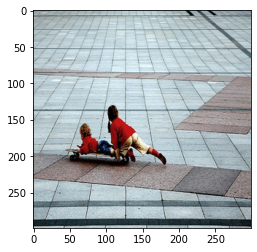

In [ ]:
plt.imshow(get_image(dev_list[0]))
image_decoder(enc_dev[0])

# Beam Search Decoder

Modify the simple greedy decoder for the caption generator to use beam search. 
Instead of always selecting the most probable word, use a *beam*, which contains the n highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). I recommend that you use a list of `(probability, sequence)` tuples. After each time-step, prune the list to include only the n most probable sequences. 

Then, for each sequence, compute the n most likely successor words. Append the word to produce n new sequences and compute their score. This way, you create a new list of n*n candidates. 

Prune this list to the best n as before and continue until `MAX_LEN` words have been generated. 

Note that you cannot use the occurence of the `"<END>"` tag to terminate generation, because the tag may occur in different positions for different entries in the beam. 

Once `MAX_LEN` has been reached, return the most likely sequence out of the current n. 

In [ ]:
def img_beam_decoder(n, image_enc):
  input = [word_to_id["<START>"]]
  array = [[input, 0.0]]
  
  while len(array[0][0]) < MAX_LEN:
    temp = []
    
    for seq in array:
      captions_num = pad_sequences([seq[0]], maxlen=40, padding ='post')
      captions_num_np = np.asarray([captions_num]).reshape((1,40))
      img = np.asarray([image_enc]).reshape((1,2048))
      probability = model.predict([img, captions_num_np]) 
      prob_seq = np.argsort(probability[0])[-n:]
      
      for i in prob_seq:
        p = seq[1]
        p += probability[0][i]
        next_caption = seq[0][:]
        next_caption.append(i)
        temp.append([next_caption, p])
                    
    array = temp
    # Sort by highest total probability
    array = sorted(array, reverse=False, key= lambda x: x[1])
    array = array[-n:]
    
  array = array[-1][0]

  temporary_caption=[]
  for i in array:
    temporary_caption.append(id_to_word[i])

  # Most probable sequence
  caption = []
  for i in temporary_caption:
    if i != "<END>":
      caption.append(i)
    else:
        break

  caption.append("<END>")
  return caption

In [ ]:
img_beam_decoder(3, enc_dev[1])

['<START>', 'a', 'person', 'climbing', 'a', 'rock', 'face', '.', '<END>']

Greedy Output:  ['<START>', 'a', 'man', 'sits', 'on', 'a', 'bench', 'with', 'a', 'baby', 'in', 'his', 'hand', '.', '<END>']
Beam Search at n=3:  ['<START>', 'a', 'young', 'girl', 'sits', 'on', 'a', 'bench', '.', '<END>']
Beam Search at n=5: ['<START>', 'a', 'little', 'girl', 'sitting', 'on', 'a', 'bench', '.', '<END>']


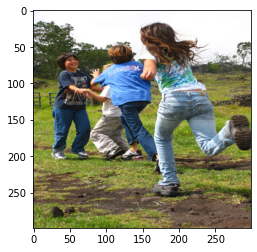

In [ ]:
plt.imshow(get_image(dev_list[7]))
print("Greedy Output: ", image_decoder(enc_dev[7]))
print("Beam Search at n=3: ", img_beam_decoder(3, enc_dev[7]))
print("Beam Search at n=5:", img_beam_decoder(5, enc_dev[7]))

Greedy Output:  ['<START>', 'a', 'man', 'and', 'a', 'dog', 'are', 'walking', 'along', 'a', 'hill', 'looking', 'at', 'camera', '.', '<END>']
Beam Search at n=3:  ['<START>', 'there', 'are', 'two', 'dogs', 'looking', 'at', 'the', 'camera', '.', '<END>']
Beam Search at n=5: ['<START>', 'a', 'group', 'of', 'dogs', 'are', 'playing', 'dogs', '.', '<END>']


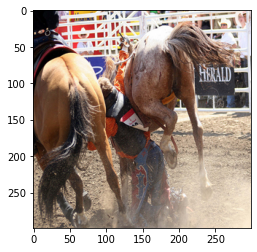

In [ ]:
plt.imshow(get_image(dev_list[77]))
print("Greedy Output: ", image_decoder(enc_dev[77]))
print("Beam Search at n=3: ", img_beam_decoder(3, enc_dev[77]))
print("Beam Search at n=5:", img_beam_decoder(5, enc_dev[77]))

Greedy Output:  ['<START>', 'a', 'man', 'in', 'a', 'baseball', 'uniform', 'swings', 'a', 'tennis', 'bat', '.', '<END>']
Beam Search at n=3:  ['<START>', 'a', 'baseball', 'player', 'swings', 'the', 'ball', '.', '<END>']
Beam Search at n=5: ['<START>', 'a', 'baseball', 'player', 'playing', 'baseball', '.', '<END>']


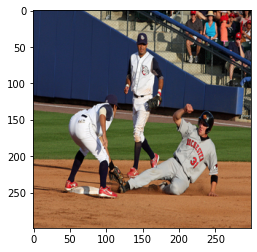

In [ ]:
plt.imshow(get_image(dev_list[100]))
print("Greedy Output: ", image_decoder(enc_dev[100]))
print("Beam Search at n=3: ", img_beam_decoder(3, enc_dev[100]))
print("Beam Search at n=5:", img_beam_decoder(5, enc_dev[100]))

Greedy Output:  ['<START>', 'a', 'basketball', 'player', 'a', 'ball', '.', '<END>']
Beam Search at n=3:  ['<START>', 'a', 'basketball', 'player', 'the', 'ball', '.', '<END>']
Beam Search at n=5: ['<START>', 'a', 'basketball', 'player', 'the', 'ball', '.', '<END>']


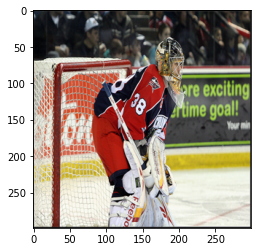

In [ ]:
plt.imshow(get_image(dev_list[200]))
print("Greedy Output: ", image_decoder(enc_dev[200]))
print("Beam Search at n=3: ", img_beam_decoder(3, enc_dev[200]))
print("Beam Search at n=5:", img_beam_decoder(5, enc_dev[200]))

Greedy Output:  ['<START>', 'a', 'man', 'and', 'a', 'woman', 'posing', 'for', 'a', 'picture', '.', '<END>']
Beam Search at n=3:  ['<START>', 'a', 'group', 'of', 'young', 'women', 'are', 'posing', 'for', 'a', 'picture', '.', '<END>']
Beam Search at n=5: ['<START>', 'a', 'group', 'of', 'people', 'posing', 'for', 'a', 'picture', '.', '<END>']


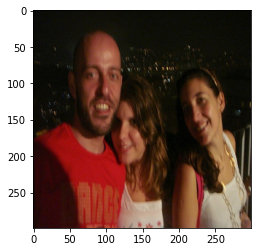

In [ ]:
plt.imshow(get_image(dev_list[123]))
print("Greedy Output: ", image_decoder(enc_dev[123]))
print("Beam Search at n=3: ", img_beam_decoder(3, enc_dev[123]))
print("Beam Search at n=5:", img_beam_decoder(5, enc_dev[123]))